# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Hacked by BlackOut

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.


In [64]:
# Added MIC required dependencies
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, re
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt
import csv, json
import shutil

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information

### MIC Specific
To load covid19api.com json response
// is not reading the EOF to check

In [65]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename
URL2 = "https://api.covid19api.com/all"
LINELIST_PATH2 = 'data/covid19api.json'

if not os.path.exists(LINELIST_PATH2):
    print('Downloading file, this will take a while ~100mb')
    try:
        print('Downloading file - start')
        download_file(URL2, LINELIST_PATH2)
        clear_output(wait=True)
        print('Done downloading.')
    except Exception as err:
        print("OS error: {0}".format(err))
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Done downloading.


#### To transform json to csv and translate headers for compatibility with covidtracking.com

In [66]:
fileInput1 = LINELIST_PATH2
fileOutput1 = 'data/covid19api.csv'

if not os.path.exists(fileOutput1):
    inputFile = open(fileInput1) 
    outputFile = open(fileOutput1, 'w') 
    data = json.load(inputFile) 
    inputFile.close() 
    print('Writing CSV')
    for item in data:
        item['positive'] = item.pop('Confirmed')
        item['state'] = item.pop('CountryCode')
        item['recovered'] = item.pop('Recovered')
        item['death'] = item.pop('Deaths')
        item['date'] = item.pop('Date')
    output = csv.writer(outputFile) 
    output.writerow(data[0].keys())  
    for row in data:
        output.writerow(row.values()) 
    print('Done writing.')
else:
    print('Already downloaded CSV')

Writing CSV
Done writing.


#### Continue with loads, this is for US ONLY, deactivated for MIC

In [67]:
#url = 'https://covidtracking.com/api/v1/states/daily.csv'

#states = pd.read_csv(url,
#                     parse_dates=['date'],
#                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
#states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])


#### Selecting and filtering MIC Countries... do I have to add CR??

In [68]:

url = fileOutput1

states = pd.read_csv(url,
                     parse_dates=['date']
                     )
#removed from origianl index_col=['state', 'date']).sort_index()
# Note: Selectin MIC OPERATIONS only
states.loc[states['state'] == 'BO', 'Keep'] = 'True'
states.loc[states['state'] == 'CO', 'Keep'] = 'True'
states.loc[states['state'] == 'GT', 'Keep'] = 'True'
states.loc[states['state'] == 'HN', 'Keep'] = 'True'
states.loc[states['state'] == 'NI', 'Keep'] = 'True'
states.loc[states['state'] == 'PA', 'Keep'] = 'True'
states.loc[states['state'] == 'PY', 'Keep'] = 'True'
states.loc[states['state'] == 'SV', 'Keep'] = 'True'
states.loc[states['state'] == 'CR', 'Keep'] = 'True'

is_mic_country=states['Keep'] == 'True'
states=states[is_mic_country]
states['date']=pd.to_datetime(states['date']).dt.date
states=states.set_index(['state', 'date'])

states=states.sort_index()
states

Country Province City  CityCode    Lat    Lon  Active  \
state date                                                                    
BO    2020-01-22      Bolivia      NaN  NaN       NaN -16.29 -63.59       0   
      2020-01-23      Bolivia      NaN  NaN       NaN -16.29 -63.59       0   
      2020-01-24      Bolivia      NaN  NaN       NaN -16.29 -63.59       0   
      2020-01-25      Bolivia      NaN  NaN       NaN -16.29 -63.59       0   
      2020-01-26      Bolivia      NaN  NaN       NaN -16.29 -63.59       0   
...                       ...      ...  ...       ...    ...    ...     ...   
SV    2020-06-03  El Salvador      NaN  NaN       NaN  13.79 -88.90    1468   
      2020-06-04  El Salvador      NaN  NaN       NaN  13.79 -88.90    1515   
      2020-06-05  El Salvador      NaN  NaN       NaN  13.79 -88.90    1547   
      2020-06-06  El Salvador      NaN  NaN       NaN  13.79 -88.90    1600   
      2020-06-07  El Salvador      NaN  NaN       NaN  13.79 -88.90    1657   

                  positive  recovered  death  Keep  
state date                                          
BO    2020-01-22         0          0      0  True  
      2020-01-23         0          0      0  True  
      2020-01-24         0          0      0  True  
      2020-01-25         0          0      0  True  
      2020-01-26         0          0      0  True  
...                    ...        ...    ...   ...  
SV    2020-06-03      2705       1186     51  True  
      2020-06-04      2781       1214     52  True  
      2020-06-05      2849       1249     53  True  
      2020-06-06      2934       1281     53  True  
      2020-06-07      3015       1305     53  True  

[1242 rows x 11 columns]

#### Clean data with known modifications, not used by MIC

In [69]:
# Errors in Covidtracking.com
#states.loc[('WA','2020-04-21'), 'positive'] = 12512
#states.loc[('WA','2020-04-22'), 'positive'] = 12753 
#states.loc[('WA','2020-04-23'), 'positive'] = 12753 + 190

#states.loc[('VA', '2020-04-22'), 'positive'] = 10266
#states.loc[('VA', '2020-04-23'), 'positive'] = 10988

#states.loc[('PA', '2020-04-22'), 'positive'] = 35684
#states.loc[('PA', '2020-04-23'), 'positive'] = 37053

#states.loc[('MA', '2020-04-20'), 'positive'] = 39643

#states.loc[('CT', '2020-04-18'), 'positive'] = 17550
#states.loc[('CT', '2020-04-19'), 'positive'] = 17962

#states.loc[('HI', '2020-04-22'), 'positive'] = 586

#states.loc[('RI', '2020-03-07'), 'positive'] = 3

#### Integrity Check

In [70]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
#### AVOIDING ASSERTION CHECKS FOR MANUAL INSERTS
# Let's make sure that states have added cases
idx = pd.IndexSlice
display(states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna())
display(states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0))
#assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
BO   2020-06-07
CO   2020-06-07
CR   2020-06-07
GT   2020-06-07
HN   2020-06-07
NI   2020-06-07
PA   2020-06-07
PY   2020-06-07
SV   2020-06-07
Name: date, dtype: datetime64[ns]

state  date      
HN     2020-05-12   -20.0
Name: positive, dtype: float64

state  date      
BO     2020-04-23     94.0
CO     2020-04-23    205.0
CR     2020-04-23      5.0
GT     2020-04-23     68.0
HN     2020-04-23      9.0
NI     2020-04-23      1.0
PA     2020-04-23    345.0
PY     2020-04-23      0.0
SV     2020-04-23     13.0
Name: positive, dtype: float64

state  date      
BO     2020-04-23    False
CO     2020-04-23    False
CR     2020-04-23    False
GT     2020-04-23    False
HN     2020-04-23    False
NI     2020-04-23    False
PA     2020-04-23    False
PY     2020-04-23     True
SV     2020-04-23    False
Name: positive, dtype: bool

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [71]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename

URL = "https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz"
#URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
#LINELIST_PATH = 'data/linelist.csv'
LINELIST_PATH = 'data/latestdata.tar.gz'
LINELIST_PATH2 = 'data/'
if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        print('Downloading file - start')
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading. Now extracting tar.gz')
        shutil.unpack_archive(LINELIST_PATH, LINELIST_PATH2)
        print('Done extracting to data/latestdata.csv')
    except Exception as err:
        print("OS error: {0}".format(err))
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded tar.gz')

Done downloading. Now extracting tar.gz
Done extracting to data/latestdata.csv


#### Load data for P

In [72]:
# Load the patient CSV
patients = pd.read_csv(
    'data/latestdata.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

patients = patients.replace('01.31.2020', '31.01.2020')
patients = patients.replace('31.04.2020', '30.04.2020')

#print(patients['Confirmed'].count)
# Only keep if both values are present
patients = patients.dropna()
# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
def fix_length(date_value):
    return date_value[:10]
#patients['Confirmed'].apply(lambda x: fix_length(x))
#patients['Onset'].apply(lambda x: fix_length(x))
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]
#patients = patients.dropna()
#print('start writing')
#patients.to_csv('data/patients.csv',index=True)
#print('done writing')
patients.head()
#moving month to day position
#wrong_date = lambda x: x.str.extract(r'^(1[0-2]|0?[1-9]).(3[01]|[12][0-9]|0?[1-9]).[0-9]{4}$')
#fix_date = lambda x: x.str[2:]
#extr = patients['Confirmed'].str.extract(r'^[0-9]{2}[.]([0][6-9]|[1][0-9])[.][2][0][1-2]([9]|[0])', expand=False)
#extr.head(20)

,Onset,Confirmed
53,08.02.2020,14.02.2020
55,01.02.2020,13.02.2020
335,30.01.2020,14.02.2020
365,14.02.2020,16.02.2020
446,11.02.2020,15.02.2020


##### Optional date fix test only

In [12]:
def is_wrong(date_value):
    res=date_value
    day = date_value[:2]
    month = date_value[3:5]
    year = date_value[6:10]
    if year == '2020':
        if int(month)>6:
            if int(day)<=6:
                res=month+'.'+day+'.'+year
    if year == '2019':
        if int(month)>12:
            if int(day)<=12:
                res=month+'.'+day+'.'+year
    
    return res
#is_wrong('05.13.2019')
patients['Confirmed'].apply(lambda x: is_wrong(x))
patients['Onset'].apply(lambda x: is_wrong(x))
print('start writing')
patients.to_csv('data/patients1.csv',index=True)
print('done writing')

start writing
done writing


In [73]:

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')
#patients = patients.dropna()
# Only keep records where confirmed > onset
patients = patients[patients.Confirmed > patients.Onset]
#print('start writing')
#patients.to_csv('data/patients2.csv',index=True)
#print('done writing')
patients['dif'] = patients.Confirmed - patients.Onset
patients[patients.dif == '0 days']

,Onset,Confirmed,dif


#### Show Relationship between Onset of Symptoms and Confirmation

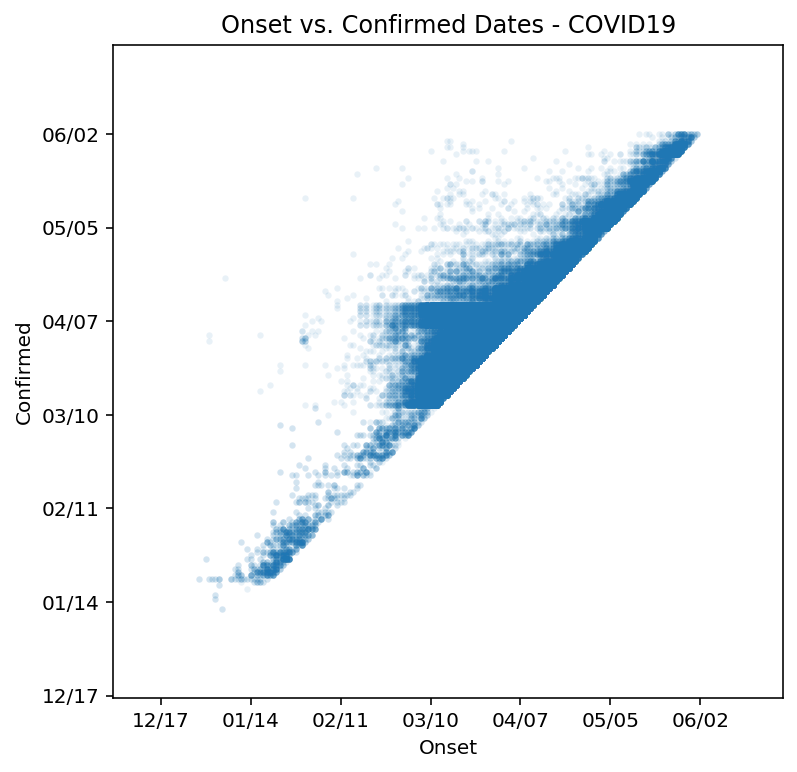

In [74]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=4)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

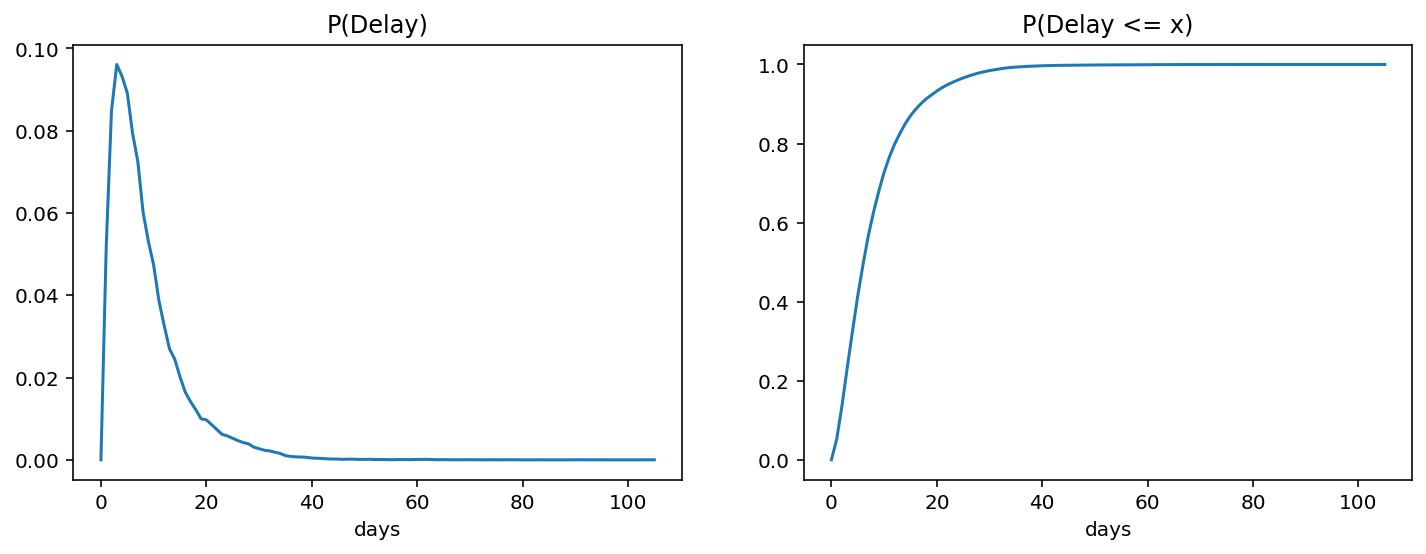

In [75]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days
# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [76]:
state = 'CO'
confirmed = states.xs(state).positive.diff().dropna()
confirmed.tail()

date
2020-06-03    1342.0
2020-06-04    1531.0
2020-06-05    3293.0
2020-06-06       0.0
2020-06-07    1390.0
Name: positive, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [77]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)
print('start writing')
onset.to_csv('data/onset1.csv',index=True)
print('done writing')

start writing
done writing


### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [78]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

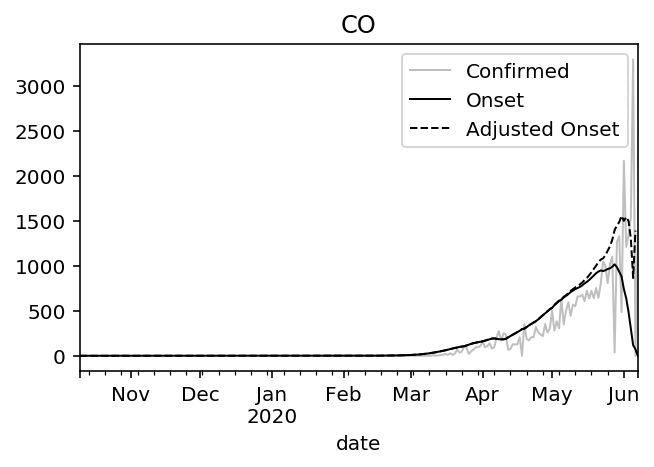

In [79]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [80]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [81]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [82]:
models = {}

for state, grp in states.groupby('state'):

    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_run_model(state,grp.droplevel(0))

BO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:36<00:00, 109.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:48<00:00, 82.61it/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


CR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 242.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


GT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:27<00:00, 144.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


HN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:29<00:00, 134.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 131.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 103.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


PY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 164.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


SV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:34<00:00, 114.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [83]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


CO    1
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:51<00:00, 78.21it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


## Compile Results

In [84]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

### Render to CSV
Uncomment if you'd like

In [85]:
snapshot='data/rt_mic_'+datetime.today().strftime('%Y_%m_%d')+'.csv'
results.to_csv(snapshot)

### Render Charts

In [86]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.5, 1.6)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

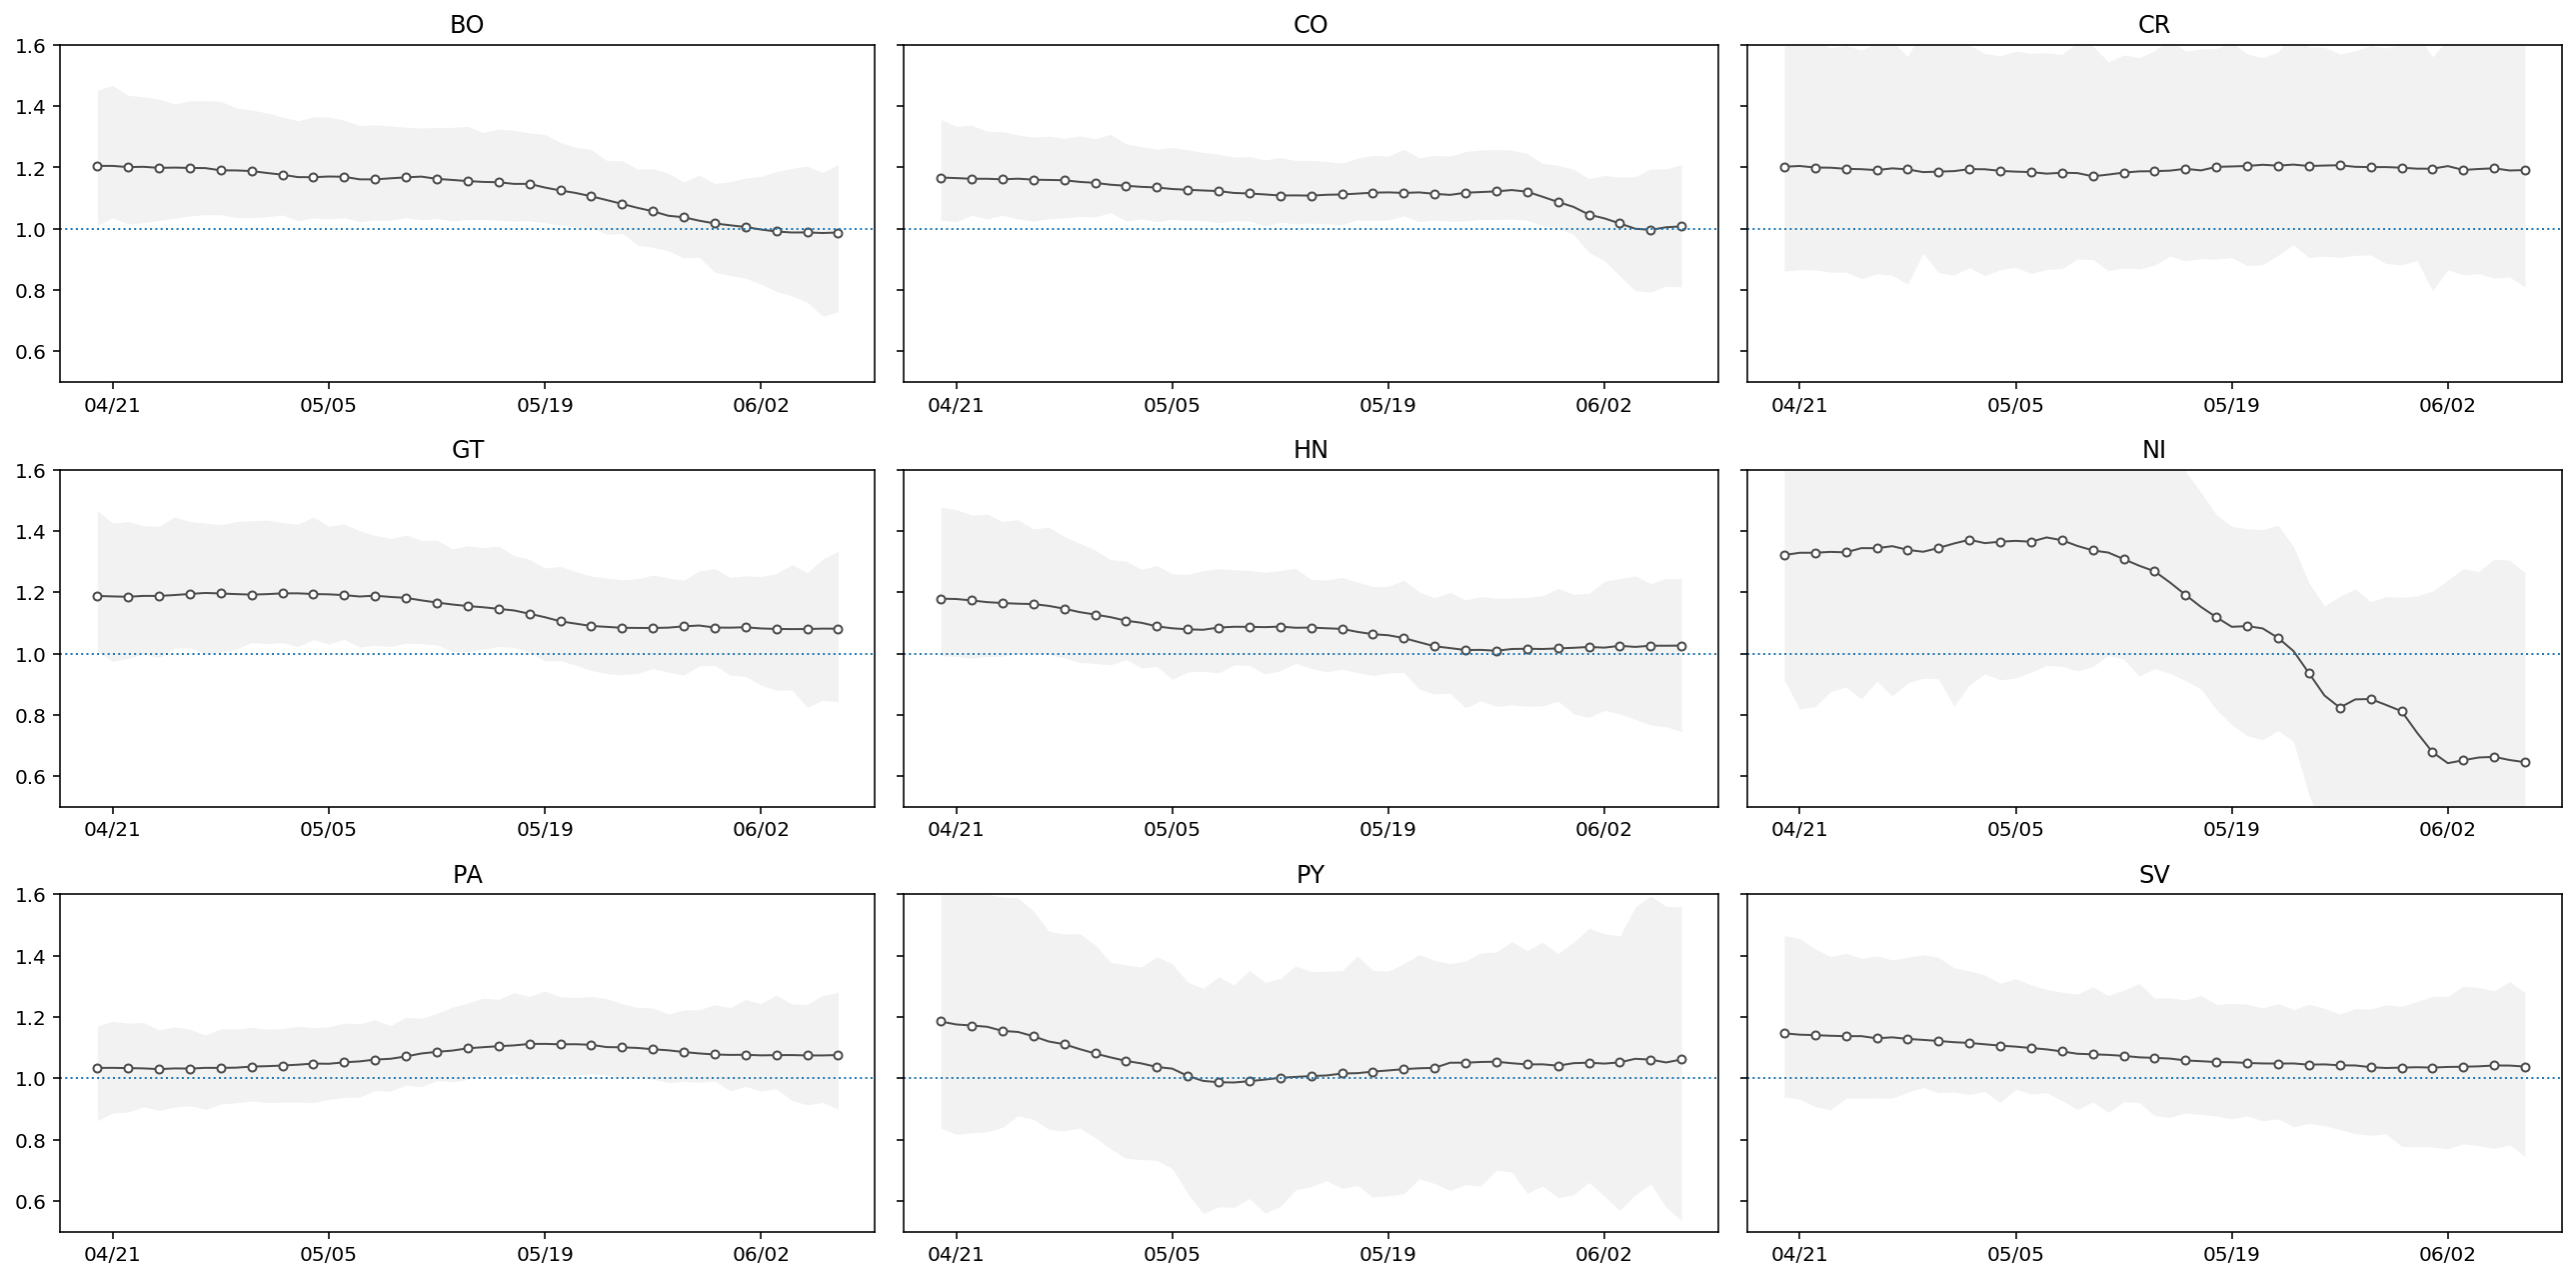

In [87]:
ncols = 3
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(18, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')